In [1]:
from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.apg import train as apg
from brax.training.agents.apg import networks as apg_networks
from brax.io import html, mjcf, model
from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
from jax import vmap
import jax.random
from jax import lax

In [2]:
from utils.SimpleConverter import SimpleConverter
from agent_mimic_env.agent_template import HumanoidTemplate
from agent_mimic_env.agent_eval_template import HumanoidEvalTemplate
from agent_mimic_env.agent_training_template import HumanoidTrainTemplate
from utils.util_data import *
from copy import deepcopy

In [3]:
import agent_mimic_env
from agent_mimic_env import register_mimic_env

In [4]:

import distutils.util
import os
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


In [5]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [6]:
import yaml
from box import Box
# Path to your YAML file
yaml_file_path = 'config_params/punch.yaml'
# Load the YAML file
with open(yaml_file_path, 'r') as file:
    args = Box(yaml.safe_load(file))

In [7]:
from agent_mimic_env.pds_controllers_agents import feedback_pd_controller, stable_pd_controller_action


In [8]:
env_replay,env_eval, env=register_mimic_env(args)

#for the eval here we run the trained policy
jit_reset = jax.jit(env_eval.reset)
jit_step = jax.jit(env_eval.step)

env_eval.set_pd_callback(stable_pd_controller_action)

env.set_pd_callback(stable_pd_controller_action)

In [9]:
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

In [10]:
from RLALG import agent_diffmimic as diff
from RLALG import agent_ppo as ppo
from RLALG import ppo_angent_networks as ppo_networks

In [11]:
episode_len = env_eval.rollout_lenght
print(episode_len)
print(env.err_threshold)

65
1.5


In [12]:
make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(512,256),
        value_hidden_layer_sizes=(512,256))
make_networks_factory

functools.partial(<function make_ppo_networks at 0x7f3f647aafc0>, policy_hidden_layer_sizes=(512, 256), value_hidden_layer_sizes=(512, 256))

num of eval after init 9
env step per traning step 92160
training steps per epoch 1
Episode lenght 64
Obs size 193


/tmp/ipykernel_15348/4318932.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, num_steps* 1.25])
/tmp/ipykernel_15348/4318932.py:52: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([0, num_steps* 1.25])


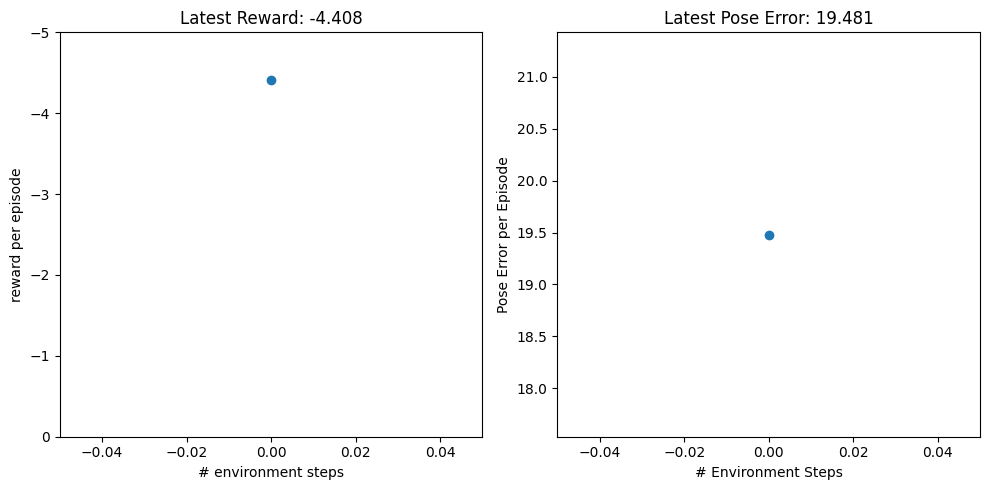

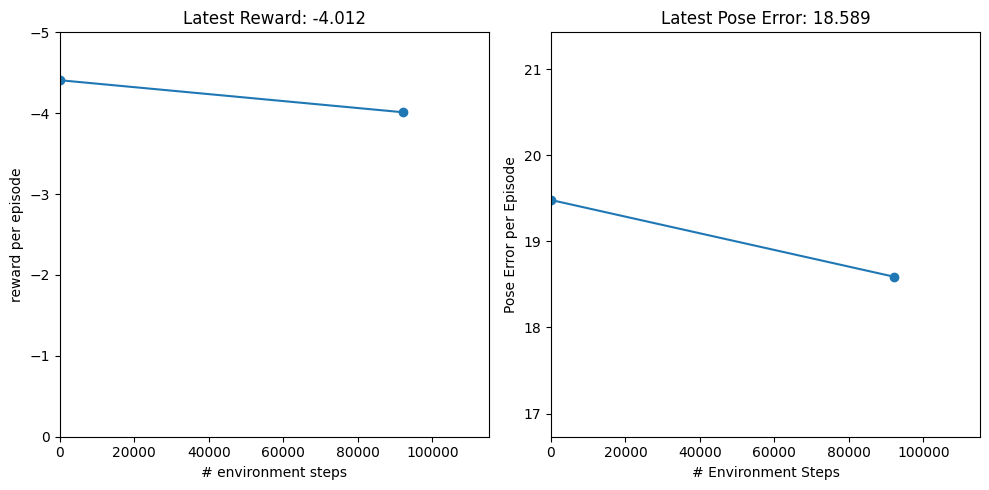

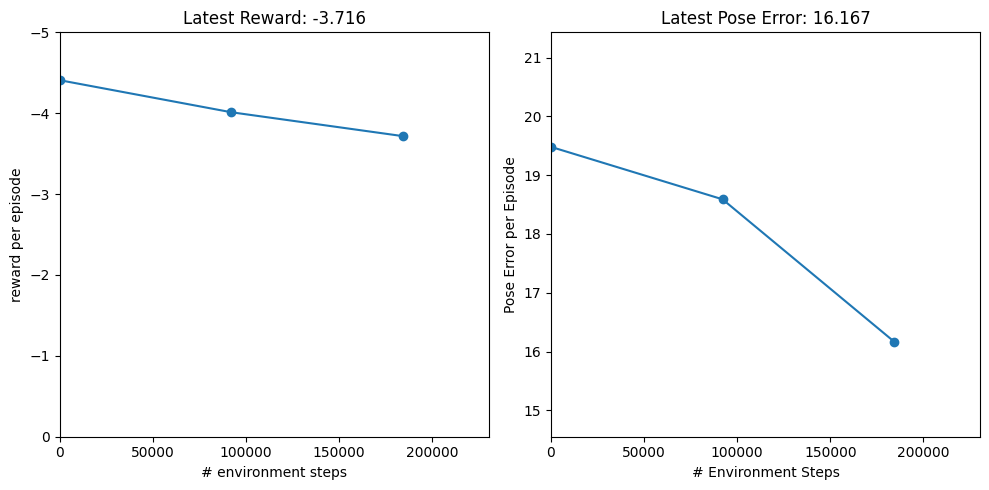

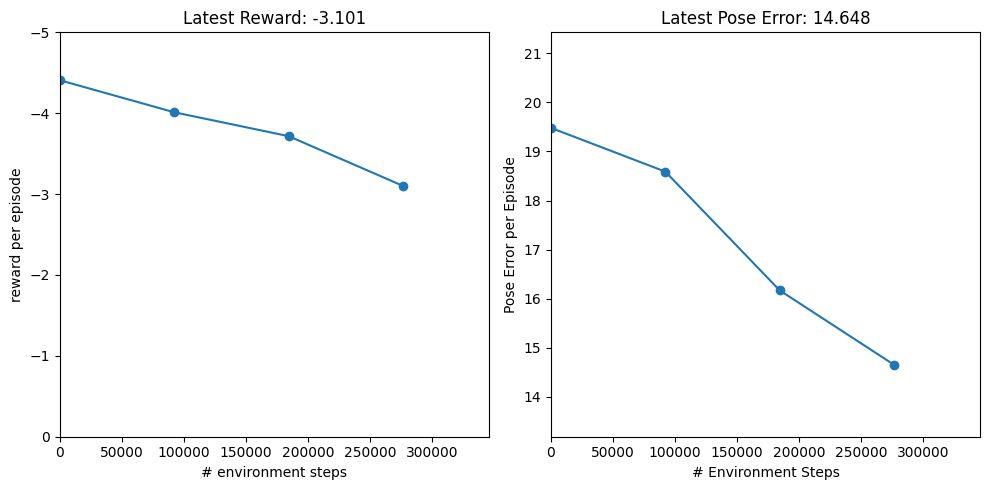

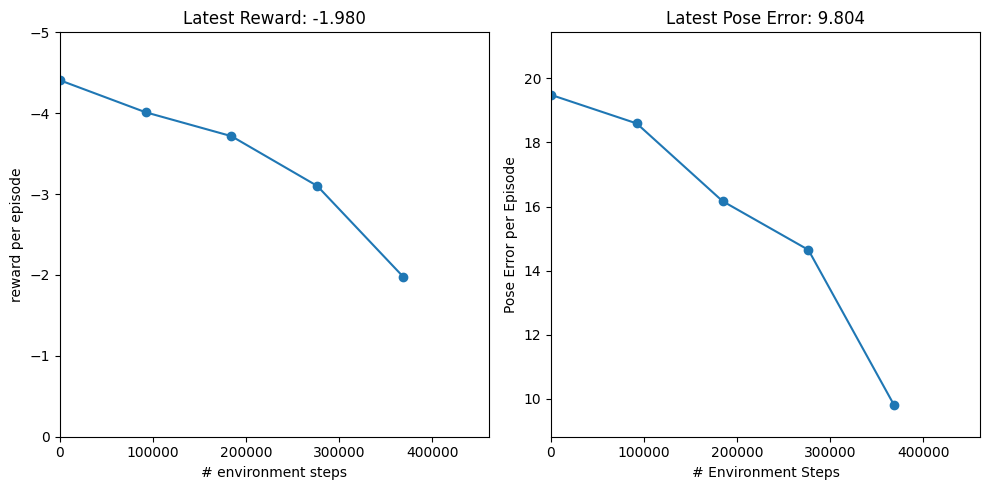

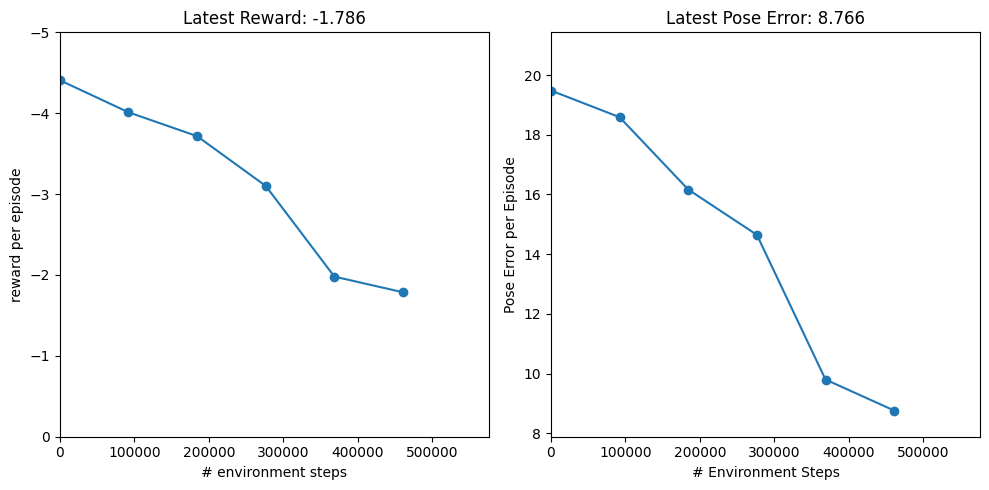

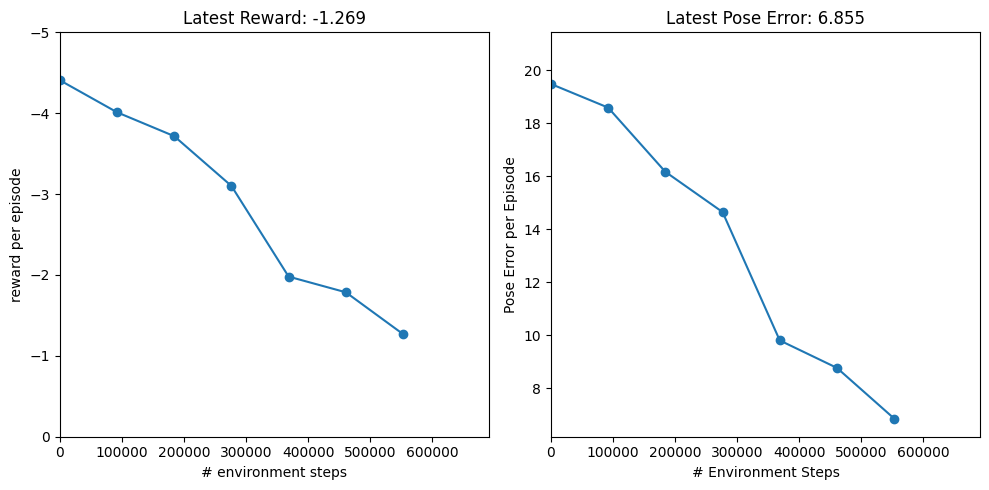

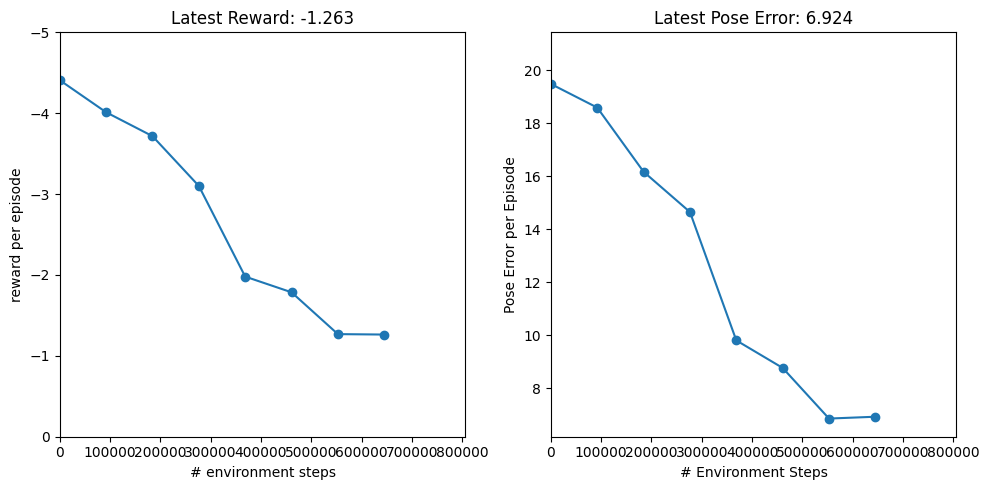

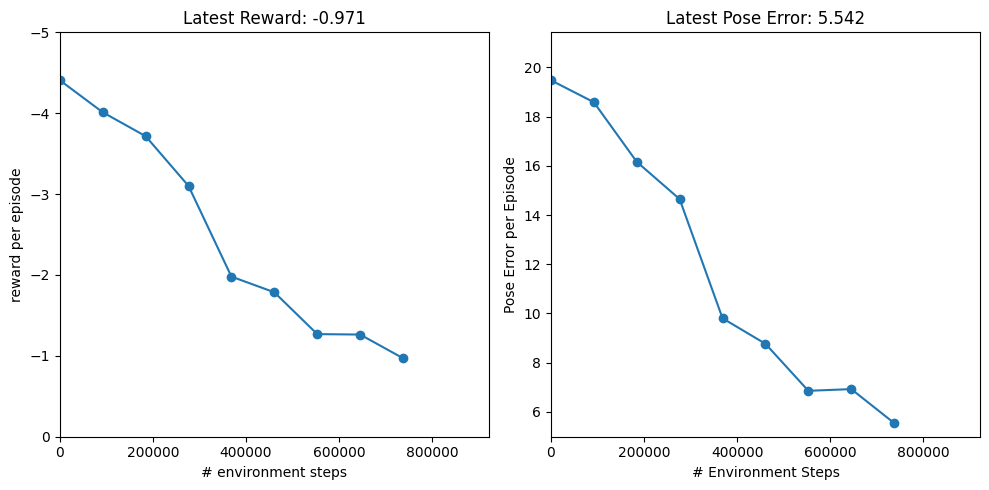

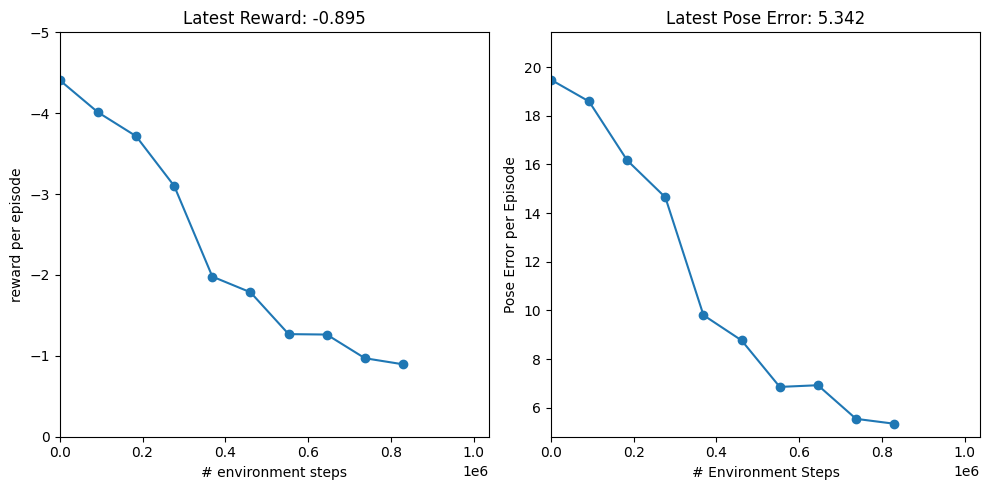

time to jit: 0:01:27.693272
time to train: 0:13:07.674297


In [13]:
train_fn = functools.partial(
    ppo.train,
    num_timesteps=1000,  # Total timesteps for training
    #num_timesteps=100_000_000,  # Total timesteps for training
    num_evals=10,
    #num_eval_envs=128
    num_eval_envs=args.num_eval_envs,
    reward_scaling=1,
    episode_length=episode_len-1,  # Ensure episode_len is defined
    normalize_observations=args.normalize_observations,
    action_repeat=1,
    unroll_length=15,
    num_minibatches=24,  # Adjusted number of minibatches
    num_updates_per_batch=4,
    discounting=0.97,  # Discount factor γ
    learning_rate=3.0e-4,
    entropy_cost=1e-2,
    num_envs=256,  # Changed number of parallel environments to match batch size
    batch_size=256,  # Adjusted batch size
    network_factory=make_networks_factory,
    seed=0  # Random seed for reproducibility
)



x_data = []
y_data = []
ydataerr = []
y_pose_error = []  # to store pose error
times = [datetime.now()]
max_y_rewards, min_y_rewards = 0, -5
def progress(num_steps, metrics):
  
  #print(num_steps)
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])
  y_pose_error.append(metrics['eval/episode_pose_error'])  # capture pose error
  
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1) 
  plt.xlim([0, num_steps* 1.25])
  plt.ylim([max_y_rewards, min_y_rewards])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'Latest Reward: {y_data[-1]:.3f}')
  plt.plot(x_data, y_data, '-o')
  
  plt.subplot(1, 2, 2)
  plt.xlim([0, num_steps* 1.25])
  plt.ylim([min(y_pose_error) * 0.9, max(y_pose_error) * 1.1])
  plt.xlabel('# Environment Steps')
  plt.ylabel('Pose Error per Episode')
  plt.title(f'Latest Pose Error: {y_pose_error[-1]:.3f}')
  plt.plot(x_data, y_pose_error, '-o')
  

  plt.tight_layout()
  plt.show()
  
make_inference_fn, params, _= train_fn(environment=env_eval,
                                       progress_fn=progress,
                                       eval_env=env_eval)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [14]:
import os

# Create a directory if it does not exist
os.makedirs('model_checkpoints', exist_ok=True)

# Save in the subdirectory
model_path = 'model_checkpoints/model_punch5_policy'
model.save_params(model_path, params)

In [15]:
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [16]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    break

In [17]:
HTML(html.render(env_eval.sys.replace(dt=env_eval.dt), rollout))